$$\textbf{Machine Learning. Tarea 7: Pix2Pix}$$
$$\textit{Y. Sarahi García Gozález}$$

<font size=4 color='mediumslateblue'>  

$\textit{Librerías}$

In [41]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
import sklearn as sk
import scipy as sp
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image



In [42]:
print("Tarea realizada en Kaggle. \nLas versiones de las librerías y de python utilizadas fueron:\n")
from platform import python_version
print("Python version:", python_version())
print("NumPy version:", np.__version__)
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE") 


Tarea realizada en Kaggle. 
Las versiones de las librerías y de python utilizadas fueron:

Python version: 3.10.13
NumPy version: 1.26.4
Tensor Flow Version: 2.15.0
Scikit-Learn 1.2.2
SciPy 1.11.4
GPU is available


In [43]:
len(tf.config.list_physical_devices('GPU'))

2

<font size=4 color='mediumslateblue'>  

$\textit{Prepocesamiento de los datos}$

Descargué los datos y para cargar los mapas de prfundidad utilicé la libreria read_depht que proporciona la página de donde obtuvimos el dataset

In [44]:
def depth_read(filename):
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=int)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png.astype(float) / 256.
    depth[depth_png == 0] = -1.
    return depth

In [45]:
def load_data(datos_phat):
    #listas vacias para almacenar las imagenes y los mapas de profundidad
    images = []
    depth_maps = []
    #creamos un lista con los directorios que se encuentra dentro de la carpeta "datos"
    directorios = os.listdir(datos_phat)
    for directorio in directorios: #iteramos sobre éstos 

        #si dentro de "datos" se encuentra un archivo .DS_Store, lo ignoramos (esto pasa en sistema MacOs)
        if directorio=='.DS_Store':
            continue

        #guardamos ruta de directorio imagenes
        image_directorio = os.path.join(datos_phat, directorio, "image")
        #guardamos ruta de directorio mapas de profundidad
        depth_map_directorio = os.path.join(datos_phat, directorio, "groundtruth_depth")

        #creamos una lista de los archivos dentro del directorio imagenes
        image_files = os.listdir(image_directorio)
        #creamos una lista de los archivos dentro del directorio mapas d profundudad
        depth_map_files = os.listdir(depth_map_directorio)

        #iteramos sobre las listas anteriores 
        for image_file, depth_map_file in zip(image_files, depth_map_files):
            #creamos la ruta completa de la imagen actual
            image_path = os.path.join(image_directorio, image_file)
            #leemos
            image = cv2.imread(image_path)
            #ajutamo la escala
            image = cv2.resize(image,(224, 224) )

            #creamos la ruta completa del mapa actual
            depth_map_path = os.path.join(depth_map_directorio, depth_map_file)
            #leemos
            depth_map = depth_read(depth_map_path)
            depth_map =  cv2.resize(depth_map, (224, 224))

            #agregmos la imagen y el mapa actuales a las listas correspondiente
            images.append(image)
            depth_maps.append(depth_map)

    return np.array(images), np.array(depth_maps)

In [46]:
#cargamos los datos usando la funcion load data
path = "/kaggle/input/kitti-data-set/datos"
X, y = load_data(path)

Aumentemos el numero de imagenenes en el conjunto  X y y

In [8]:

datagen = ImageDataGenerator(
    rotation_range=20,      #rotación aleatoria en grados
    width_shift_range=0.1,  #esplazamiento horizontal aleatorio
    height_shift_range=0.1, #Desplazamiento vertical aleatorio
    shear_range=0.2,        # Intensidad de la deformación de cizalla
    zoom_range=0.2,         #rango de zoom aleatorio
    horizontal_flip=True,  #Volteo horizontal aleatorio
    fill_mode='nearest'     #Modo de relleno para los píxeles fuera de los límites de la imagen original
)


batch_size = 64
num_augmented_images = 1000  # Número de imágenes a generar
num_batches = num_augmented_images // batch_size
#listas vacias para datos aumentds
X_uaumentado = []
y_uaumentado = []

for batch in range(num_batches):
    #Generamos un lote de imágenes aumentadas y etiquetas correspondientes
    augmented_data = next(datagen.flow(X, y, batch_size=batch_size, shuffle=False))
    #Extraemos las imágenesy las etiquetas 
    X_batch_augmented, y_batch_augmented = augmented_data
    #La agregamos a los conjuntos corresp.
    X_uaumentado.append(X_batch_augmented)
    y_uaumentado.append(y_batch_augmented)

# Convertimos la lista de lotes de imágenes aumentadas en un único conjunto
X_uaumentado = np.concatenate(X_uaumentado, axis=0)
y_uaumentado = np.concatenate(y_uaumentado, axis=0)



Ahora concatenamos las imágenes y mapas aumentados con los conjuntosoriginales

In [9]:
X = np.concatenate([X, X_uaumentado], axis=0)

In [73]:
np.shape(X)

(2960, 224, 224, 3)

In [10]:
y = np.concatenate([y, y_uaumentado], axis=0)

In [75]:
np.shape(y)

(2960, 224, 224)

Se pide:
* Entrada: imágenes rgb+ en 224x224 pixéles
* Salida: imágenes escala de gris codificando profundidad en 224x224 pixeles

In [47]:
print("Shape of images X:", X.shape)
print("Shape of depth maps y:", y.shape)

Shape of images X: (2000, 224, 224, 3)
Shape of depth maps y: (2000, 224, 224)


In [78]:
X = X.astype('float32') / 255.0
Y = y.astype('float32') / 255.0

Dividimos en entrenamiento 80% y prueba 20%

In [48]:
#Entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1600, 224, 224, 3)
Shape of y_train: (1600, 224, 224)
Shape of X_test: (400, 224, 224, 3)
Shape of y_test: (400, 224, 224)


(-0.5, 223.5, 223.5, -0.5)

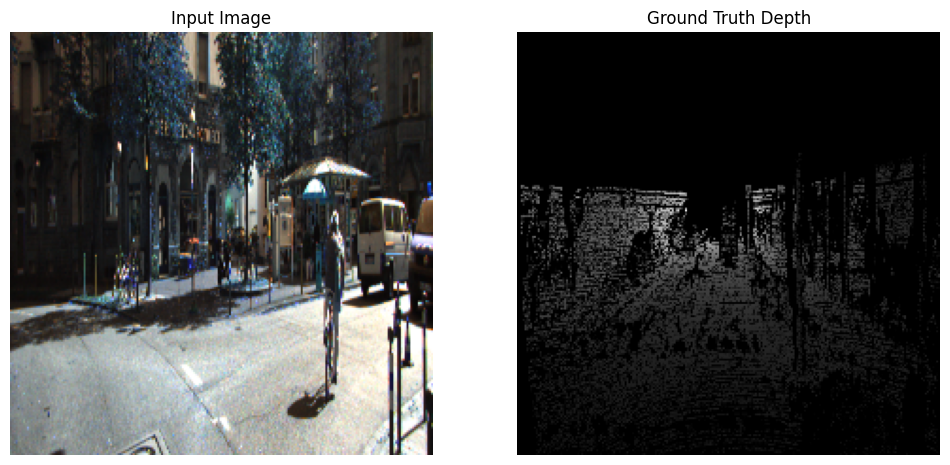

In [62]:
ejem=1 #ejemplo imagen aumentada
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(X_train[ejem])
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(y_train[ejem], cmap='gray')
plt.title('Ground Truth Depth')
plt.axis('off')

In [87]:
y_train[1]

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

<font size=4 color='mediumslateblue'>  

$\textit{Arquitecturas}$

In [65]:
#https://keras.io/examples/vision/oxford_pets_image_segmentation/
def get_unet(trainable):
    # Ruta de los pesos de VGG16
    weights_path = '/Users/ely/Documents/pre-trained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

    # Imágenes RGB de 224x224 pixeles para la entrada
    img_size = (224, 224, 3)  

    # Usamos VGG16 con los pesos preentrenados, solo la etapa de extracción de características, y input de 224x224 RGB
    conv_base = VGG16(weights="imagenet", include_top=False, input_shape=img_size)
    conv_base.trainable = trainable

    # Codificador
    encoder_output = conv_base.get_layer("block5_pool").output

    # Decodificador
    
    # Entry block
    x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu')(encoder_output)
    x = layers.Concatenate()([x, conv_base.get_layer("block5_conv3").output])
    #  Block 2
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, conv_base.get_layer("block4_conv3").output])
    #  Block 3
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, conv_base.get_layer("block3_conv3").output])
    #  Block 4
    x = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, conv_base.get_layer("block2_conv2").output])

    #Salida de una sola canal con sigmoid como activacion
    outputs = layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='sigmoid')(x)

    #Definimos el modelo
    model = tf.keras.Model(inputs=conv_base.input, outputs=outputs)

    return model


In [66]:
####el discriminador en la arquitectura pix2pix intenta
#### distinguir entre imágenes reales (en este caso de profundidad) 
#### y las generadas por la red generadora (en este caso la UNET)
### Para hacerlo, utiliza una serie de capas convolucionales que procesan las imágenes 
### de entrada y emiten una predicción sobre si la imagen de profundidad es real o generada

def get_discriminator():
    # Tamaño de entrada de la imagen
    img_size = (224, 224, 3)
    tar_size = (224, 224)
    
    # Entrada de la imagen RGB (224, 224, 3)
    input_image = layers.Input(shape=(224, 224, 3), name='input_image')
    # Entrada de la imagen de profundidad (224, 224, 1)
    target_image = layers.Input(shape=(224, 224,1), name='target_image')
    
    # Concatenar las imágenes en el eje de canales
    x = layers.concatenate([input_image, target_image], axis=-1)  # (224, 224, 4)
    
    #En las siguientes capas convolucionales usaremos como activacion LeakyReLU
    #Esta funcion introduce no linealidad en la red 
    # ayuda a evitar que las unidades queden completamente inactiva
    
    #capa conv1
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x) 
    #capa conv2
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    #capa conv3
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    #capa conv4
    x = layers.Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    #Salida de una sola canal con sigmoid como activacion
    x = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(x)
    #definimos el modelo
    model = tf.keras.Model(inputs=[input_image, target_image], outputs=x)
    
    return model



In [67]:
#El objetivo del modelo pix2pix es
#generar una imagen de salida (en este caso, un mapa de profundidad) 
#a partir de una imagen de entrada (en este caso, una imagen RGB), 
#de manera que la imagen generada sea indistinguible de las imágenes reales (los mapas de profundidad reales)
#según lo evaluado por el discriminador.

def get_pix2pix(generator, discriminator):
    #imagen rgb
   
    input_im = layers.Input(shape=(224, 224, 3), name='input_image')
    #mapa de profundidad (real)
    target_im = layers.Input(shape=(224, 224, 1), name='real_image')
    
    #Generamos el mapa de profundidad con la UNET
    generated_im = generator(input_im)
    
    #evaluamosa con el discriminador si el mapa GENERADO es real o falsa 
    #(tomando como referencia la imagen de entrada)
    disciminator_generated= discriminator([input_im, generated_im])
    
    #evaluamosa con el discriminador si el mapa REAL es real o falsa
    #(tomando como referencia la imagen de entrada)
    discriminator_real = discriminator([input_im, target_im])
    
    # Definir el modelo
    model = tf.keras.Model(inputs=[input_im, target_im],
                           outputs=[disciminator_generated, discriminator_real, generated_im])
    
    return model

<font size=4 color='mediumslateblue'>  

$\textit{Funciones de pérdida}$

In [52]:
#use como referencia las notas del curso, sección Funciones de Pérdida (Losses) de la GAN
#http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/pix2pix/pix2pix.html

def discriminator_loss(disc_real_output, disc_generated_output):
    '''
    disc_generated_output: Las predicciones del discriminador para las imágenes generadas.
    disc_generated_output: Las predicciones del discriminador para las imágenes generadas.
    '''
    #El costo del discriminador lo calcularemos mediate la entropía cruzada (crossentropy):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss #loss total del discriminador


def generator_loss(disc_generated_output, gen_output, target):
    '''
    el generador debe entrenarse para maximizar los errores de detección de imágenes sintéticas
    disc_generated_output: Las predicciones del discriminador para las imágenes generadas.
    gen_output: Los mapas generadas por el generador
    target: mapas reales.
    '''
    # Entropia cruzada a partir de logits
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(disc_generated_output), disc_generated_output)
    # Media de los Errores Absolutos
    l1_loss = tf.keras.losses.MeanAbsoluteError()(target, gen_output)
    #unsamos LAMBDA = 100 como en el ejempplo de la clase
    return gan_loss + (100 * l1_loss) #loss total del generador 


<font size=4 color='mediumslateblue'>  

$\textit{Optimizadores}$

<font size=4 color='mediumslateblue'>  

$\textit{Crear y compilar, y entrenar modelo}$

In [68]:
#construimos genrador 
generator = get_unet(False)
generator.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 19,206,945 (73.27 MB)

 Trainable params: 4,492,257 (17.14 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [69]:
#construimos discriminador
discriminator = get_discriminator()
discriminator.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 224, 224,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 4)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 112, 112,  │      4,160 │ concatenate_14[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 112, 112,  │          0 │ conv2d_10[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 56, 56,    │    131,200 │ leaky_re_lu_8[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28,    │    524,544 │ leaky_re_lu_9[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 28, 28,    │  2,097,664 │ leaky_re_lu_10[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      2,048 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 28, 28, 1) │      8,193 │ leaky_re_lu_11[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,769,345 (10.56 MB)

 Trainable params: 2,767,553 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [73]:
# Definir el entrenamiento
def train_step(input_image, target, generator, discriminator, gen_optimizer, disc_optimizer):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(np.expand_dims(input_image, axis=0), training=True)
        
        disc_real_output = discriminator([np.expand_dims(input_image, axis=0),np.expand_dims(np.expand_dims(target, axis=0), axis=3)], training=True)
        disc_generated_output = discriminator([np.expand_dims(input_image, axis=0),np.expand_dims(np.expand_dims(target, axis=0), axis=3)], training=True)
        
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Ejemplo de bucle de entrenamiento
def fit(x_train,y_train, epochs):
    
    gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    for epoch in range(epochs):
        for input_image, target in zip(x_train,y_train):
            gen_loss, disc_loss = train_step(input_image, target, generator, discriminator, gen_optimizer, disc_optimizer)
        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}')



In [74]:
num_epochs=15
fit(X_train,y_train, num_epochs)

Epoch 1, Gen Loss: 330.6403503417969, Disc Loss: 15.778531074523926
Epoch 2, Gen Loss: 332.8597717285156, Disc Loss: 15.580016136169434
Epoch 3, Gen Loss: 333.7633361816406, Disc Loss: 15.853560447692871
Epoch 4, Gen Loss: 330.22357177734375, Disc Loss: 15.697136878967285
Epoch 5, Gen Loss: 327.028564453125, Disc Loss: 15.309602737426758
Epoch 6, Gen Loss: 327.5846252441406, Disc Loss: 15.943466186523438
Epoch 7, Gen Loss: 327.32501220703125, Disc Loss: 15.814738273620605
Epoch 8, Gen Loss: 327.8561096191406, Disc Loss: 15.933856964111328
Epoch 9, Gen Loss: 328.0671081542969, Disc Loss: 15.883722305297852
Epoch 10, Gen Loss: 329.0379333496094, Disc Loss: 15.800107955932617
Epoch 11, Gen Loss: 328.5968933105469, Disc Loss: 15.900644302368164
Epoch 12, Gen Loss: 328.6590576171875, Disc Loss: 15.884673118591309
Epoch 13, Gen Loss: 328.24407958984375, Disc Loss: 15.915855407714844
Epoch 14, Gen Loss: 328.2295837402344, Disc Loss: 15.769590377807617
Epoch 15, Gen Loss: 329.30206298828125, D

<font size=4 color='mediumslateblue'>  

$\textit{Predicción}$

In [75]:
y_pred= generator.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step


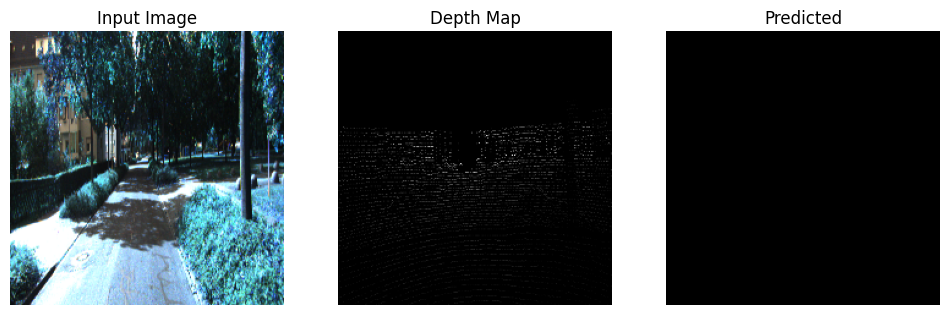

In [76]:
ejem2=141

plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(X_test[ejem2])
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_test[ejem2], cmap='gray')
plt.title('Depth Map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_pred[ejem2], cmap='gray')
plt.title('Predicted')
plt.axis('off')

plt.show()